In [1]:
%matplotlib inline
import numpy as np
from astropy.io import ascii
from astropy.table import Table
from astropy.table import join

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context("talk")
sns.set_style("ticks")

In [2]:
# Fulton & Petigura 2018
ful_star   = Table.read("../data/Fulton2018_stellarradii_ajaae828t2_mrt.txt", format='ascii')
ful_planet = Table.read("../data/Fulton2018_planetradii_ajaae828t3_mrt.txt", format='ascii')

ful_planet['KOI_star'] = np.array([(x.split(".")[0]) for x in ful_planet['KOI']])
ful_star.rename_column('KOI', 'KOI_star')

ful_planet = join(ful_planet, ful_star, join_type='left', keys='KOI_star')

In [3]:
#The Cumulative KOI table includes all stars which were ever given the
#Kepler Object of Interest (KOI) designation by the Kepler team. 
#There were multiple data releases and in the interim the analysis pipelines changed.
koic  = Table.read('../data/koi-cumulative.tbl', format='ascii')
#We will rename the 'kepoi_name' column of the table to simply 'KOI' in order to join it to the
#Fulton & Petigura 2018 table.
koic.rename_column('kepoi_name', 'KOI')

from astropy.table import join
ful_planet = join(ful_planet, koic, join_type='left', keys='KOI')

#One of the columns we will want to look at is the transit depth. 
#This comes from the Cumulative KOI table, and is accessed with the key 'koi_depth'.
#The units are ppm (parts per million). Recall that transit depth = (Rp/R*)^2. 
#Let's verify this ourselves by plotting the transit depth vs. the planet-to-star radius ratio
#from the Fulton table.

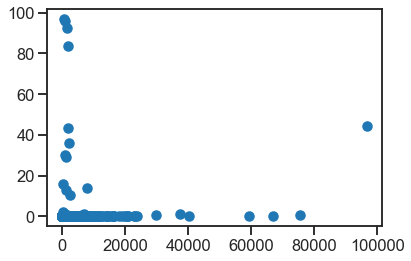

In [4]:
plt.scatter(ful_planet['koi_depth'],ful_planet['Rp/R*'])

Before going further, let's look at how we can 'combine' boolean arrays or masks. We have already gone over how to evaluated whether some condition is True/False over a certain column. Next, we want to evaluate whether two or more conditions hold true across different columns.

In [5]:
#Boolean operations follow these rules:
#True * True = True
#True * False = False
#False * False = False

# Here is an example of combining boolean arrays.
_x = np.array([True, True, False, False])
_y = np.array([True, False, True, False])
print(_x*_y)

#What if we include a third condition?
_z = np.array([False, True, True, True])
print(_x*_y*_z)

#We can understand what's going on as:
#(True * True) * False = False
#(True * False) * True = False
#(False * True) * True = False
#(False * False) * True = False
#So long as one element is False, any product will always be False.

[ True False False False]
[False False False False]


In [6]:
#ful_planet['koi_disposition'][0:20] == 'CONFIRMED'
#plt.scatter(ful_planet['KOI'],ful_planet['koi_depth'])
#plt.hist(ful_planet['koi_disposition'])
#ful_planet['ful_depth'][0:10]
#ful_planet['koi_depth']
ful_planet['Rp/R*'][0:10]

0.123851
0.075408
0.294016
0.024735
0.018559
0.093582
0.095137
0.080126
0.117936
0.093941


[ True  True False]


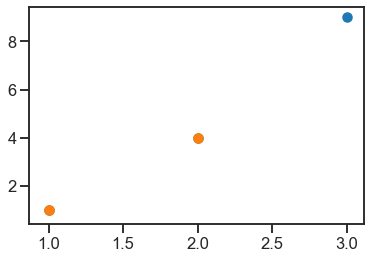

In [7]:
x = np.array([1,2,3])
y = x**2
temp = y < 8
print(temp)
plt.scatter(x,y)
plt.scatter(x[temp], y[temp])

In [8]:
t = np.array([True, True, False, False])
f = np.array([True, False, True, False])
print(t&f)

[ True False False False]


In [9]:
#plt.scatter(ful_planet['ful_depth'], ful_planet['koi_depth'], c=ful_planet['koi_impact'])

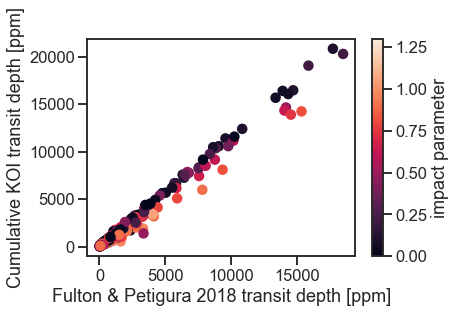

In [10]:
#First we want to mask out any planets which are not 'CONFIRMED'
confirmed = ful_planet['koi_disposition']=='CONFIRMED'

#Now, after making an initial plot it's clear that many planets have transit depths in the
#Cumulative KOI table which are inconsistent with the Rp/R* values from the 
#Fulton & Petigura 2018 table
#Let's compute the expected depth in units of parts-per-million from the Fulton Rp/R* values
ful_planet['ful_depth'] = (ful_planet['Rp/R*']**2.0)/1e-6


#Now let's identify the cases where the computed depth differs by less than 10,000 ppm from the
#value in the Cumulative KOI table
wrong_depth = abs(ful_planet['ful_depth'] - ful_planet['koi_depth'])<10000

#Now, we have two boolean arrays: one which tells us whether the planet is confirmed 
#and one which tells us whether the two transit depth values are consistent.
#We can "merge" these two boolean arrays simply with the multiplication operation
#in order to return the indices where both conditions are satisfied
arg = confirmed*wrong_depth

#Finally, we can plot the computed transit depth vs. the Cumulative KOI table transit depth.
#We will color code points by the "impact parameter." We expect that planets with low impact
#parameter values to have better agreement in the two transit depth values.

plt.scatter(ful_planet['ful_depth'][arg], ful_planet['koi_depth'][arg], c=ful_planet['koi_impact'][arg])
plt.colorbar(label='impact parameter')
plt.xlabel('Fulton & Petigura 2018 transit depth [ppm]')
plt.ylabel('Cumulative KOI transit depth [ppm]')
plt.show()

Finally, we want the "Robust RMS CDPP" values. RMS stands for root mean square, and CDPP stands for Combined Differential Photometric Precision. Essentially, this is a measurement of the noise in the relative flux time series on a specified timescale. 

We need to load yet another table to get the Robust RMS CDPP values.

To read more about CDPP see here:
https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/20170009550.pdf

In [11]:
from astropy.io import ascii
dr25 = ascii.read('../data/Kepler-Q1-Q17-DR25-KOI.txt', format='ipac')  
#dr25.info()
#Note this is a large file and the cell takes a few minutes to execute.

To join the ful_planet and dr25 tables we will use the 'kepid' column. 
This is not the same as 'KOI' but is the same as 'KIC' or Kepler Input Catalog number.

In [12]:
ful_planet = join(ful_planet, dr25, join_type='left', keys='kepid')

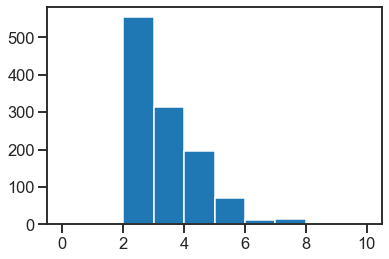

In [13]:
#This line will count the number of planets in a given system 
#(this assumes you have joined ful_star to ful_planet)
#It works because if KOI0098 has 3 planets then KOI0098 will occur 3 times 
#in the 'KOI_star' column
ful_planet['nplanets'] = [np.sum(x == ful_planet['KOI_star']) for x in ful_planet['KOI_star']]

#Line below creates boolean mask to identify multi-planet systems, so anything > 2 planets
ful_planet['multi_flag'] = ful_planet['nplanets']>1

#plots only multi-planet systems
plt.hist(ful_planet['nplanets'][ful_planet['multi_flag']], np.arange(0,11,1))
plt.show()

(0.3, 30)

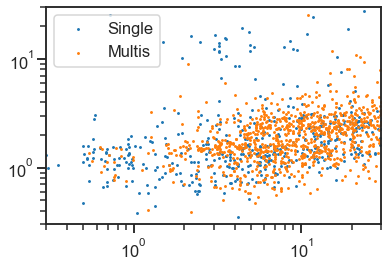

In [14]:
m = ful_planet['nkoi'] > 1
plt.scatter(ful_planet['P'][~m],ful_planet['Rp'][~m], s = 2, label = 'Single')
plt.scatter(ful_planet['P'][m],ful_planet['Rp'][m], s = 2, label = 'Multis')
plt.loglog()
plt.legend()
plt.ylim(0.3,30)
plt.xlim(0.3,30)

In [15]:
import astropy.constants as c
def minimal_transit_depth(rstar, rpmin=1.0):
    
    # Compute the transit depth of planet with radius rpmin (in Earth units)
    # around a star with radius rstar (in Solar units)
    # Returns geometric transit depth in parts-per-million
    
    return 1.0e6*((rpmin*c.R_earth)/(rstar*c.R_sun))**2. 
print(minimal_transit_depth(1.0, rpmin=1.0))

84.05017877225197


In [16]:
c.R_sun

<<class 'astropy.constants.iau2015.IAU2015'> name='Nominal solar radius' value=695700000.0 uncertainty=0.0 unit='m' reference='IAU 2015 Resolution B 3'>

In [17]:
minimal_transit_depth(ful_planet['R']) #units are wrong supposed to be ppm

<Quantity [ 93.52376174, 170.55498489,  34.14229845, ...,  50.50788941,
            94.31801518,  19.33421407] 1 / Rsun2>

In [18]:
min_radius = 1.0
ful_planet['min_transit'] = minimal_transit_depth(ful_planet['R'], min_radius)

In [19]:
ful_planet['snr_min'] = ful_planet['min_transit'] / ful_planet['rrmscdpp04p5']


In [20]:
ful_planet['snr_min'][:10]

0.30047312249323654
2.683454244737052
0.40806877717954515
1.208138840502434
1.208138840502434
1.208138840502434
1.2248823411898495
0.5323934900231929
0.5323934900231929
0.7435519862911438


Text(0, 0.5, 'Planet Radius [Earth radii]')

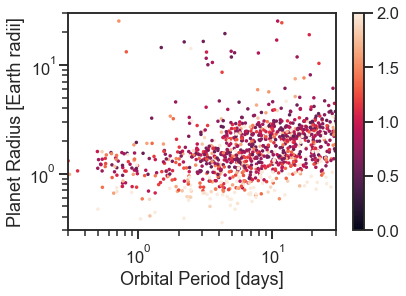

In [21]:
snr_thresh = 0.5
m = ful_planet['snr_min'] > snr_thresh
plt.scatter(ful_planet['P'][m],ful_planet['Rp'][m], s = 4, c = ful_planet['snr_min'][m], vmin = 0, vmax = 2)
plt.loglog()
plt.colorbar()
plt.ylim(0.3,30)
plt.xlim(0.3,30)
plt.xlabel("Orbital Period [days]")
plt.ylabel("Planet Radius [Earth radii]")

Now, the ful_planet table has grown considerably with many columns. Scrolling through the column names we see there are many columns with the prefix 'rrmscdpp' followed by a number. 

For example,

rrmscdpp01p5 float64     ppm MaskedColumn   1336

rrmscdpp02p0 float64     ppm MaskedColumn   1336

rrmscdpp02p5 float64     ppm MaskedColumn   1336

etc.

This is because stars exhibit noise on different timescales, and the CDPP is pre-computed for each Kepler star for a set number of timescales which are meant to cover the range of transit timescales represented in the data. If your transit is 2.5 hours long, you want the column called "rrmscdpp02p5", but if your transit is 9.0 hours long, you would want the column called "rrmscdpp09p0".

This is not likely to be the most important step in the analysis. After some exploration of the data set it seems clear that for most Kepler stars, the CDPP value over 1.5 hour and 15 hour timescales differs by less than 0.01%. But, to be as careful as possible we will try to extract the most relevant CDPP value for each transiting planet.

Let's first examine what transit durations are represented in our data set.

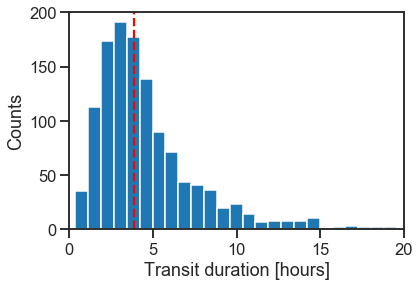

Median transit duration [hours]: 3.873


In [22]:
plt.hist(ful_planet['koi_duration'][arg], bins=101)
plt.axvline(np.median(ful_planet['koi_duration'][arg]), color='r', ls='--')
plt.xlim(0,20)
plt.xlabel('Transit duration [hours]')
plt.ylabel('Counts')
plt.show()

print('Median transit duration [hours]:', np.median(ful_planet['koi_duration'][arg]))

In [23]:
# print(abs(3.8 - np.array(cdpp_grid)))
# np.argmin(abs(3.8 - np.array(cdpp_grid)))
# print(cdpp_grid[np.argmin(abs(3.8 - np.array(cdpp_grid)))])

For each planet listed in the Fulton & Petigura 2018 catalog we want to find the CDPP that best matches the transit duration of that particular planet. However, in the Kepler DR25 table we only have the CDPP values over a grid of timescales:

In hours, the grid of timescales is: 
[1.5, 2.0, 2.5, 3.0, 3.5, 4.5, 5.0, 6.0, 7.5, 9.0, 10.5, 12.0, 12.5, 15.0]

In [24]:
#Let's define a variable that represents the grid of timescales for which CDPP is computed.
cdpp_grid = [1.5, 2.0, 2.5, 3.0, 3.5, 4.5, 5.0, 
             6.0, 7.5, 9.0, 10.5, 12.0, 12.5, 15.0]
cdpp_suffix = ['01p5', '02p0', '02p5', '03p0', '03p5', '04p5', '05p0', 
               '06p0', '07p5', '09p0', '10p5', '12p0', '12p5', '15p0']
#The suffixes will be used to get the correct CDPP value from the dr25 table

#Now, let's create a new column in our table to represent the CDPP. 
#We will initialize this column with zeros everywhere.
ful_planet['cdpp'] = np.zeros(len(ful_planet))

#Next, we will loop through every planet listed in the Fulton & Petigura 2018 catalog
#and we will figure out which timescale in the grid is closest to the actual transit duration

for i in range(len(ful_planet)):
    
    #This returns the absolute value of the difference between the true transit duration
    #and the timescales represented in the CDPP grid 
    duration_diff = abs(ful_planet['koi_duration'][i]-cdpp_grid)
    #We now want the argument (index) of the CDPP grid element 
    #which is closest to the true transit duration (i.e. smallest difference)
    _arg = np.argmin(duration_diff)
    #Now, we will assign the correct pre-computed CDPP value to the CDPP column
    ful_planet['cdpp'][i] = ful_planet['rrmscdpp'+cdpp_suffix[_arg]][i]

As a sanity check, let's look at the distribution of CDPP values among planet hosts in the Fulton & Petigura 2018 catalog vs. the distribution for *all* Kepler stars (even those with no known transiting planets)

I expect the planet hosts should have smaller CDPP values on average (because transiting planets can only be found around the quietest (least noisy) stars

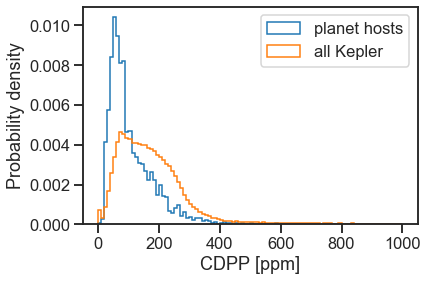

In [25]:
plt.hist(ful_planet['cdpp'], bins=np.linspace(0,1000,101), histtype='step', density=True, label='planet hosts')
plt.hist(dr25['rrmscdpp03p5'], bins=np.linspace(0,1000,101), histtype='step', density=True, label='all Kepler')
plt.legend()
plt.xlabel('CDPP [ppm]')
plt.ylabel('Probability density')
plt.show()

As expected, the orange histogram for all Kepler stars is preferentially shifted toward higher CDPP values (more noise in the light curve). The planet hosting stars represent a quieter subset with lower CDPP values (less noise in the light curve = easier to detect planets).

Great! Now that we have the CDPP values for each transiting planet *and* the transit depths, both in units of parts-per-million, we can calculate approximate signal-to-noise of a single transit for each planet in the data table. We'll make a column called 'single_transit_snr'. SNR stands for signal-to-noise ratio.

Here, the signal is the transit depth and the noise is the CDPP.

In [26]:
ful_planet['single_transit_snr'] = ful_planet['ful_depth']/ful_planet['cdpp']

In [27]:
ful_planet['single_transit_snr'][:10]

37.57326469917211
12.32787803153416
--
2.308655244580183
1.9639570618065787
2.8616942930688642
0.6265372221831069
1.0078912878684094
0.8528991448638785
2.3376292938087055


Finally, let's make our period-radius scatter plot and color code the points according to single transit SNR. We should expect that small planets tend to have smaller SNR, and large planets have higher SNR.

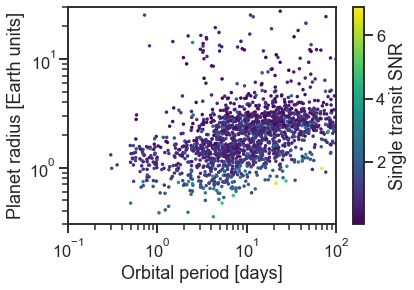

In [28]:
plt.scatter(ful_planet['P'], ful_planet['Rp'], 
            c=ful_planet['snr_min'], 
             s=4, cmap='viridis'
           )
plt.loglog()
plt.xlim(0.1,100)
plt.ylim(0.3,30)
plt.xlabel('Orbital period [days]')
plt.ylabel('Planet radius [Earth units]')
plt.colorbar(label='Single transit SNR')
plt.show()

We also want to look at whether the single transit SNR has any dependence on age.
Let's look at small planets and large planets separately.

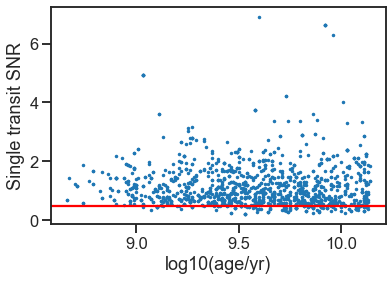

In [29]:
small_planets = ful_planet['Rp']<1.5
large_planets = ful_planet['Rp']>1.5
arg = ful_planet['R'] < 1.5

plt.scatter(ful_planet['logAiso'][arg], ful_planet['snr_min'][arg], 
            vmin=0, vmax=4, s=4, cmap='viridis')
plt.xlabel('log10(age/yr)')
plt.ylabel('Single transit SNR')
plt.axhline(0.5, color = 'red')
#plt.colorbar(label='Planet size [Earth units]')
plt.savefig('snr.jpg', bbox_inches='tight',dpi = 300)

In [30]:
pwd

'/Users/Angeli/Desktop/multis/notebooks'

It's not immediately obvious that there is a trend between age and single transit SNR. We need to investigate further and look at completeness (rather than SNR).

In [31]:
print(len(ful_planet))

1901


In [32]:
print(len(ful_planet))
m = ful_planet['nplanets'] > 1
#print(len(ful_planet[m]))
m &= ful_planet['P'] < 100
print(len(ful_planet[m]))
m &= ful_planet['snr_min'] > 0.5 #still need to define value
print(len(ful_planet[m]))
m &= ful_planet['R'] < 1.5
print(len(ful_planet[m]))
m &= ful_planet['r8'] < 1.1
print(len(ful_planet[m]))
m &= np.invert(ful_planet['RCF'] > 1.05)
print(len(ful_planet[m]))
m &= ful_planet['E_Rp']/ful_planet['Rp'] < 0.5
print(len(ful_planet[m]))

#mask_1 = ful_planet[m] #new astropy table with only rows m is true #gives error 2nd time running

1901
1082
862
797
739
721
714


/Users/Angeli/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


8.5
9.0
9.5
10.0


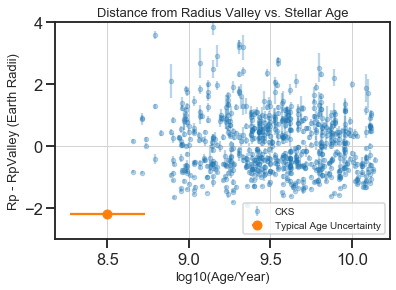

In [33]:
def Rp_valley(P):
    return 10**(-0.09*np.log10(P) + .37)

ful_planet["Rp_valley"] = Rp_valley(ful_planet['P'])
ful_planet['R_diff'] = ful_planet["Rp"] - ful_planet["Rp_valley"]

#short_period = ful_planet["P"] < 30
#long_period = ful_planet["P"] > 30
#plt.scatter(ful_planet["logAiso"][short_period],ful_planet["R_diff"][short_period],s = 8,alpha = 0.3, label = "Short Period")
plt.errorbar(ful_planet["logAiso"][m],ful_planet["R_diff"][m], yerr = [ful_planet['e_Rp'][m], ful_planet['E_Rp'][m]], fmt = '.',alpha = 0.3, label = 'CKS')
plt.errorbar(8.5, -2.2, xerr=np.mean(ful_planet['E_logAiso'][m]), fmt='o', label = 'Typical Age Uncertainty') #typical uncertainty in stellar age
plt.legend(prop = {'size': 10}, loc = 'lower right')
plt.xlabel("log10(Age/Year)",size = 13)
plt.ylabel("Rp - RpValley (Earth Radii)",size = 13)
plt.title('Distance from Radius Valley vs. Stellar Age',size = 13)
plt.ylim(-3,4)
plt.axhline(0, color = 'lightgrey', lw = 1)

_bins = np.arange(8.5,10.5,0.5)
for b in _bins:
    plt.axvline(b, color = 'lightgrey', lw = 1)
    print(b)
plt.savefig("rp-rpvalley.jpg",bbox_inches='tight',dpi = 300)

In [34]:
print(ful_planet['Rp'][:10])

  Rp  
 Rgeo 
------
12.384
 2.416
    --
 1.355
  1.38
 1.624
 0.791
 1.431
 1.221
  1.98


In [35]:
print(ful_planet['Rp_valley'][:10])

    Rp_valley     
        d         
------------------
1.9258442943912555
1.7766765721518927
1.5348165272128087
1.5688009553325233
1.8602136163649134
1.7759992966812617
2.2714383531147457
2.0014593290267415
1.9037726404754367
1.6825957270740788


In [36]:
print(ful_planet['R_diff'][:10])

       R_diff       
        Rgeo        
--------------------
  10.458155705608744
  0.6393234278481073
                  --
 -0.2138009553325233
-0.48021361636491355
-0.15199929668126155
 -1.4804383531147458
 -0.5704593290267415
 -0.6827726404754366
  0.2974042729259212


In [37]:
print(np.max(ful_planet['E_Rp'][m]))

43.954


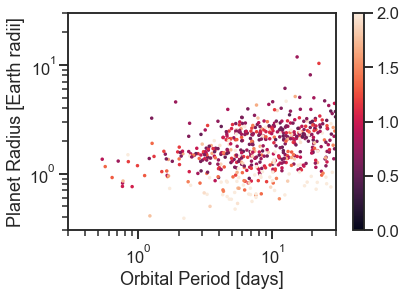

In [38]:
plt.scatter(ful_planet['P'][m],ful_planet['Rp'][m], s = 4, c = ful_planet['snr_min'][m], vmin = 0, vmax = 2)
plt.loglog()
plt.colorbar()
plt.ylim(0.3,30)
plt.xlim(0.3,30)
plt.xlabel("Orbital Period [days]")
plt.ylabel("Planet Radius [Earth radii]")
plt.savefig('fig3.pdf',bbox_inches='tight')

In [39]:
x = np.array([True, True, False, False])
y = np.array([True, False, True, False])
print(x&y)
print(x*y)
z = np.array([1,2,3,4])
print(z[x&y])


[ True False False False]
[ True False False False]
[1]


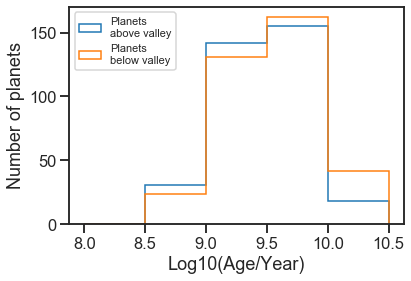

In [40]:
cond1 = ful_planet['R_diff'] > 0
cond2 = ful_planet['R_diff'] < 0
ages_above_rv = ful_planet['logAiso'][cond1&m]
ages_below_rv = ful_planet['logAiso'][cond2&m]

_bins = np.arange(8,11,0.5)

hist_below, bin_edges = np.histogram(ages_below_rv, bins = _bins, density =False)
hist_above, bin_edges = np.histogram(ages_above_rv,bins = _bins, density =False)
hist_all, bin_edges = np.histogram(ful_planet['logAiso'][m], bins = _bins, density=False)

plt.hist(ages_above_rv, bins=_bins, density=False, histtype='step', label='Planets\nabove valley')
plt.hist(ages_below_rv, bins=_bins, density=False, histtype='step', label='Planets\nbelow valley')

plt.xlabel('Log10(Age/Year)')
plt.ylabel('Number of planets')
plt.legend(loc = 'upper left',prop={'size': 11})
# plt.subplot(2,2,1)
# plt.subplot(2,2,2)
# plt.subplot(2,2,3)
# plt.subplot(2,2,4)
plt.savefig("hist.jpg",bbox_inches='tight', dpi = 300)

/Users/Angeli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/Angeli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


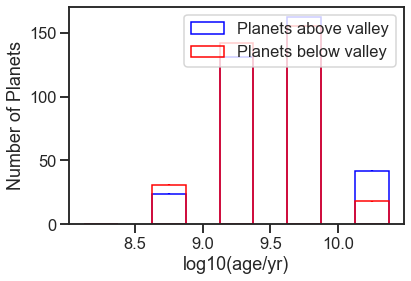

In [41]:
bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
error1 = 1.0/np.sqrt(hist_below)
error2 = 1.0/np.sqrt(hist_above)

plt.bar(bin_centers, hist_below, width=0.25, yerr=error1, facecolor='None', edgecolor='blue', 
        ecolor='blue', label='Planets above valley')
plt.bar(bin_centers, hist_above, width=0.25, yerr=error2, facecolor='None', edgecolor='red', 
        ecolor='red', label='Planets below valley')
plt.xlabel('log10(age/yr)')
plt.ylabel('Number of Planets')
plt.legend()
plt.show()

In [42]:
# n = 10000
# ratio = []
# for i in range(n):
    
#     _hist_below = np.random.normal(hist_below, error1)
#     _hist_above  = np.random.normal(hist_above, error2)
    
#     ratio.append(hist_below/hist_above)


# plt.subplot(212)
# plt.bar(bin_centers, hist_below/hist_above, width=0.25, facecolor='None', edgecolor='black', ecolor='black', 
#         label='exact')
# plt.bar(bin_centers, np.nanmean(ratio, axis=0), width=0.25, yerr=np.nanstd(ratio, axis=0), facecolor='None', 
#         edgecolor='green', ecolor='green', label='Monte Carlo')
# plt.xlim(7,11)
# #plt.ylim(0,2)
# plt.legend(loc='upper left')
# plt.xlabel('log10(age/yr)')
# plt.ylabel('# Planets Below / # Planets Above')
# plt.gcf().set_size_inches(7,7)
# plt.tight_layout()
# plt.show()

/Users/Angeli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/Angeli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/Users/Angeli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


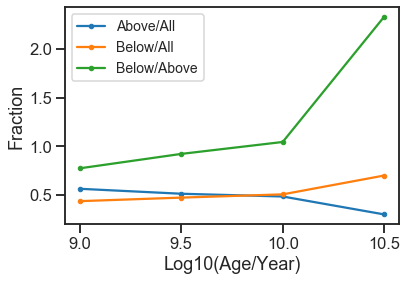

In [43]:
#fraction of planets above radius valley/all planets
plt.plot(bin_edges[1:], hist_above/hist_all, '.-', label = 'Above/All')
#fraction of planets below radius valley/all planets
plt.plot(bin_edges[1:], hist_below/hist_all,'.-',label = 'Below/All')
#fraction of planets below radius valley/planets above radius valley
plt.plot(bin_edges[1:], hist_below/hist_above, '.-',label = 'Below/Above')
plt.legend(prop={'size': 14})

plt.xlabel("Log10(Age/Year)")
plt.ylabel("Fraction")
plt.savefig("histplots.jpg",bbox_inches='tight', dpi = 300)

/Users/Angeli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/Users/Angeli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/Users/Angeli/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1541: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')


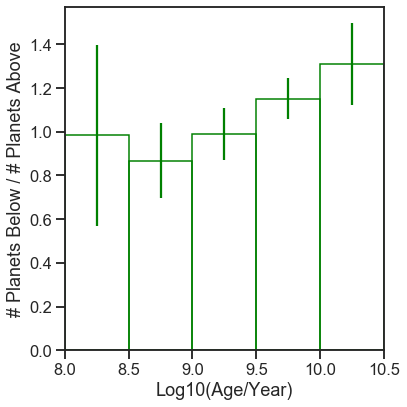

In [44]:
nsamples = 1000

_rvalley = ful_planet['Rp_valley'][m]

_minage = 8
_maxage = 12
_binwidth = 0.5
_bins = np.arange(_minage,_maxage,_binwidth)

_ratio = []

for i in range(nsamples):
    
    # In this step we simulate a data set with similar properties to the true data set.
    # We model both planet radius and age as Gaussian distributions centered on the measured values (rp and age)
    # and standard deviations equal to the previously assigned errors (_e)
    
    # Implicit in this step is that the stellar age and planet radius measurements/uncertainties are independent.
    # It is probably not true that age and radius uncertainties are independent, but we can assess the degree to
    # which that impacts our results later on.
    
    # In reality, we have asymmetric error bars on rp and age. We have to make a decision on how to deal with this.
    # If a given planet has a radius of 1.0(+0.3, -0.1) and age of 9.5(+0.5,-0.25) we could just take the maximum error
    # in both radius and age and continue to model as Gaussians, e.g. radius is 1.0 +/- 0.3, and age is 9.5 +/- 0.5
    # in the example above.
    
    _rp = np.random.normal(ful_planet['Rp'][m], np.max([ful_planet['e_Rp'][m],ful_planet['E_Rp'][m]], axis=0))
    _age = np.random.normal(ful_planet['logAiso'][m], np.max([ful_planet['e_logAiso'][m],ful_planet['E_logAiso'][m]], axis=0))
    _above = _rp >= _rvalley
    _below = _rp < _rvalley
    
    _hist1, _bin_edges = np.histogram(_age[_above], bins=_bins)
    _hist2, _bin_edges = np.histogram(_age[_below], bins=_bins)
    

    _ratio.append(_hist2/_hist1)
    

bin_centers = 0.5*(_bin_edges[1:]+_bin_edges[:-1])    
    
plt.bar(bin_centers, np.nanmean(_ratio, axis=0), width=_binwidth, 
        yerr=np.nanstd(_ratio, axis=0), facecolor='None', edgecolor='green', ecolor='green', label='Monte Carlo')
plt.xlim(8,10.5)
#plt.legend(loc='upper left')
plt.xlabel('Log10(Age/Year)')
plt.ylabel('# Planets Below / # Planets Above')
plt.gcf().set_size_inches(6,6)
plt.tight_layout()
#plt.bar(bin_centers,hist_below/hist_above)
plt.savefig("mc.jpg",bbox_inches='tight', dpi = 300)

<ErrorbarContainer object of 3 artists>

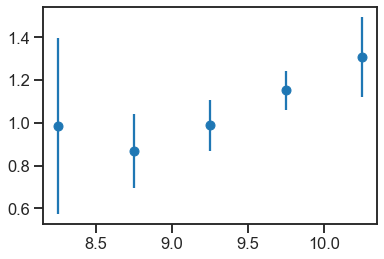

In [45]:
x_data = bin_centers
y_data = np.nanmean(_ratio, axis=0)
yerr_data = np.nanstd(_ratio, axis=0)
plt.errorbar(x_data,y_data,yerr=yerr_data, fmt = 'o')

In [46]:
import emcee

# Uniform Age Distribution

/Users/Angeli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/Users/Angeli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/Users/Angeli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice
/Users/Angeli/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


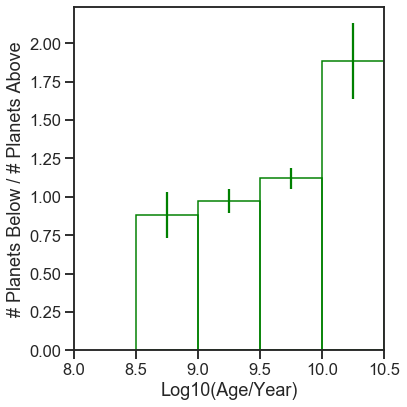

In [47]:
nsamples = 1000

_rvalley = ful_planet['Rp_valley'][m]

_minage = 8
_maxage = 12
_binwidth = 0.5
_bins = np.arange(_minage,_maxage,_binwidth)

_ratio = []

for i in range(nsamples):
    
    # In this step we simulate a data set with similar properties to the true data set.
    # We model both planet radius and age as Gaussian distributions centered on the measured values (rp and age)
    # and standard deviations equal to the previously assigned errors (_e)
    
    # Implicit in this step is that the stellar age and planet radius measurements/uncertainties are independent.
    # It is probably not true that age and radius uncertainties are independent, but we can assess the degree to
    # which that impacts our results later on.
    
    # In reality, we have asymmetric error bars on rp and age. We have to make a decision on how to deal with this.
    # If a given planet has a radius of 1.0(+0.3, -0.1) and age of 9.5(+0.5,-0.25) we could just take the maximum error
    # in both radius and age and continue to model as Gaussians, e.g. radius is 1.0 +/- 0.3, and age is 9.5 +/- 0.5
    # in the example above.
    
    _rp = np.random.normal(ful_planet['Rp'][m], np.max([ful_planet['e_Rp'][m],ful_planet['E_Rp'][m]], axis=0))
    _age = np.random.uniform(ful_planet['logAiso'][m]-ful_planet['e_logAiso'][m],ful_planet['logAiso'][m]+ful_planet['E_logAiso'][m])
    _above = _rp >= _rvalley
    _below = _rp < _rvalley
    
    _hist1, _bin_edges = np.histogram(_age[_above], bins=_bins)
    _hist2, _bin_edges = np.histogram(_age[_below], bins=_bins)
    

    _ratio.append(_hist2/_hist1)
    

bin_centers = 0.5*(_bin_edges[1:]+_bin_edges[:-1])    
    
plt.bar(bin_centers, np.nanmean(_ratio, axis=0), width=_binwidth, 
        yerr=np.nanstd(_ratio, axis=0), facecolor='None', edgecolor='green', ecolor='green', label='Monte Carlo')
plt.xlim(8,10.5)
#plt.legend(loc='upper left')
plt.xlabel('Log10(Age/Year)')
plt.ylabel('# Planets Below / # Planets Above')
plt.gcf().set_size_inches(6,6)
plt.tight_layout()
#plt.bar(bin_centers,hist_below/hist_above)
plt.savefig("mc.jpg",bbox_inches='tight', dpi = 300)

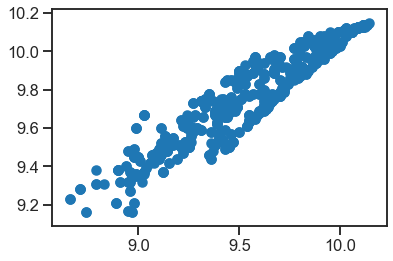

In [52]:
plt.scatter(ful_planet['logAiso'][m], ful_planet['logAiso'][m] + ful_planet['E_logAiso'][m])

In [48]:
print(len(hist_below))
print(len(bin_centers))

5
7


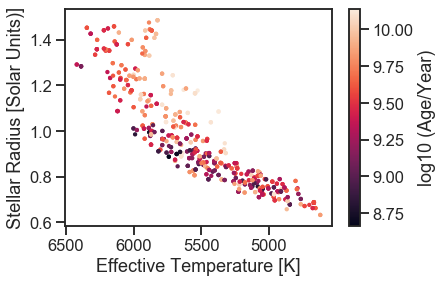

In [49]:
plt.scatter(ful_planet['Teff'][m],ful_planet['Riso'][m], s = 8, c = ful_planet['logAiso'][m])
cbar = plt.colorbar()
cbar.set_label('log10 (Age/Year)')
plt.xlabel('Effective Temperature [K]')
plt.ylabel('Stellar Radius [Solar Units)]')
plt.gca().invert_xaxis()
plt.savefig("hr.jpg",bbox_inches='tight', dpi = 300)

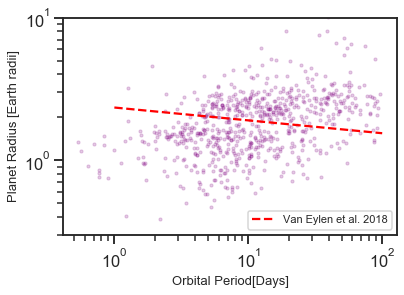

In [50]:
_x, _y = ful_planet['P'], ful_planet['Rp']

rvalley_x = np.arange(1, 101, 1)
log10_rvalley_y = -0.09*np.log10(rvalley_x) + .37
rvalley_y = 10.**log10_rvalley_y
plt.scatter(_x[m], _y[m], lw=1, s = 10, color = "purple",alpha = 0.2)
#plt.plot(rvalley_x, rvalley_y)

plt.plot(rvalley_x, rvalley_y, '--r',label = 'Van Eylen et al. 2018')

plt.xlabel("Orbital Period[Days]", size = 13)
plt.legend(loc = 'lower right',prop={'size': 11})
plt.ylabel("Planet Radius [Earth radii]", size = 13)
#plt.title("Planet Radius vs. Orbital Period", size = 13)
plt.loglog()
plt.ylim(0.3,10)
plt.savefig("pr_cuts.jpg",bbox_inches='tight', dpi = 300)
#plt.xlim(0.3,100)